# **Importing Twitter Data**

In [ ]:
import pandas as pd
import os
from google.colab import drive
drive.mount('/content/drive')
extracted_dir_path = '/content/drive/MyDrive/TwitterData'
# Load train and test data
train_data_path = os.path.join(extracted_dir_path, 'train.csv')
test_data_path = os.path.join(extracted_dir_path, 'test.csv')
# Load train and test data with specified encoding
train_data = pd.read_csv(train_data_path, encoding='ISO-8859-1')
test_data = pd.read_csv(test_data_path, encoding='ISO-8859-1')

Mounted at /content/drive


# **Data Preprocessing**

In [ ]:
# Select necessary columns in train data
train_data = train_data[['text', 'sentiment']]

# Select necessary columns in test data
test_data = test_data[['text', 'sentiment']]

# Remove null values if any
train_data = train_data.dropna()
test_data = test_data.dropna()

In [ ]:
# Lowercase the text
train_data['text'] = train_data['text'].str.lower()
test_data['text'] = test_data['text'].str.lower()

# Remove punctuation and special characters
train_data['text'] = train_data['text'].str.replace('[^\w\s]', '')
test_data['text'] = test_data['text'].str.replace('[^\w\s]', '')

# Remove stopwords
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

train_data['text'] = train_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
test_data['text'] = test_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Tokenize the text
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text'])

X_train = tokenizer.texts_to_sequences(train_data['text'])
X_test = tokenizer.texts_to_sequences(test_data['text'])

# Pad sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = max([len(x) for x in X_train + X_test])
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_data['sentiment'] = label_encoder.fit_transform(train_data['sentiment'])

# Convert sentiment labels to numeric labels for test data
test_data['sentiment'] = label_encoder.transform(test_data['sentiment'])

# Separate features (X) and target (y) for train and test data
X_train = tokenizer.texts_to_sequences(train_data['text'])
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
y_train = train_data['sentiment']

X_test = tokenizer.texts_to_sequences(test_data['text'])
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')
y_test = test_data['sentiment']


# **LSTM Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Define the model
lstm_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_len),
    LSTM(128),
    Dense(3, activation='softmax')
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(" ")
print("LSTM Model Architecture : ")
print(lstm_model.summary())
print(" ")

# Train the model
lstm_history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


 
LSTM Model Architecture : 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 31, 100)           2659400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 2777035 (10.59 MB)
Trainable params: 2777035 (10.59 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
 
Epoch 1/20
687/687 [==============================] - 36s 49ms/step - loss: 0.9443 - accuracy: 0.5349 - val_loss: 0.7594 - val_accuracy: 0.6796
Epoch 2/20
687/687 [==============================] - 6s 9ms/step - loss: 0.6443 - accuracy: 0.7405 

In [ ]:
# Evaluate the model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, y_test)
print("LSTM Test Accuracy:", lstm_accuracy)

111/111 [==============================] - 1s 5ms/step - loss: 2.1022 - accuracy: 0.6505
LSTM Test Accuracy: 0.6505376100540161


# **RNN Model**

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, Activation, Flatten
from keras.preprocessing.sequence import pad_sequences

# Pad sequences
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# Build the RNN model
rnn_model = Sequential()

# Adjust the embedding input dimension based on your vocabulary size
vocab_size = len(tokenizer.word_index) + 1

rnn_model.add(Embedding(vocab_size, 32, input_length=max_len))
rnn_model.add(SimpleRNN(16, return_sequences=False, activation="relu"))
rnn_model.add(Dense(3))  # Three classes: negative, neutral, positive
rnn_model.add(Activation("softmax"))  # Softmax for multi-class classification

# Compile the model
rnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

print(" ")
print("RNN Model Architecture : ")
print(rnn_model.summary())
print(" ")

# Train the model
rnn_history = rnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test, y_test)
print("Test Accuracy:", rnn_accuracy)


 
RNN Model Architecture : 
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 31, 32)            851008    
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                784       
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
 activation (Activation)     (None, 3)                 0         
                                                                 
Total params: 851843 (3.25 MB)
Trainable params: 851843 (3.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
 
Epoch 1/20
687/687 [==============================] - 35s 48ms/step - loss: 1.0884 - accuracy: 0.4009 - val_loss: 1

# **Bi-Directional LSTM**

In [ ]:
from keras.layers import Bidirectional

# Build the Bidirectional LSTM model
bi_lstm_model = Sequential()
bi_lstm_model.add(Embedding(vocab_size, 32, input_length=max_len))
bi_lstm_model.add(Bidirectional(LSTM(64)))
bi_lstm_model.add(Dense(3, activation='softmax'))

bi_lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(" ")
print("Bi Directional LSTM Model Architecture : ")
print(bi_lstm_model.summary())
print(" ")

# Train the model
bi_lstm_history = bi_lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
bi_lstm_loss, bi_lstm_accuracy = bi_lstm_model.evaluate(X_test, y_test)
print("Test Accuracy:", bi_lstm_accuracy)


 
Bi Directional LSTM Model Architecture : 
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 31, 32)            851008    
                                                                 
 bidirectional (Bidirection  (None, 128)               49664     
 al)                                                             
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 901059 (3.44 MB)
Trainable params: 901059 (3.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
 
Epoch 1/20
687/687 [==============================] - 19s 23ms/step - loss: 0.8323 - accuracy: 0.6164 - val_loss: 0.7009 - val_accuracy: 0.7016
Epoch 2/20
687/687 [=

# **GRU Model**

In [ ]:
from keras.layers import GRU

# Build the GRU model
gru_model = Sequential()
gru_model.add(Embedding(vocab_size, 32, input_length=max_len))
gru_model.add(GRU(64))
gru_model.add(Dense(3, activation='softmax'))

gru_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(" ")
print("Gated Recurrent Unit (GRU) Model Architecture : ")
print(gru_model.summary())
print(" ")

# Train the model
gru_history = gru_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
gru_loss, gru_accuracy = gru_model.evaluate(X_test, y_test)
print("Test Accuracy:", gru_accuracy)

 
Gated Recurrent Unit (GRU) Model Architecture : 
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 31, 32)            851008    
                                                                 
 gru (GRU)                   (None, 64)                18816     
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 870019 (3.32 MB)
Trainable params: 870019 (3.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
 
Epoch 1/20
687/687 [==============================] - 16s 21ms/step - loss: 1.0882 - accuracy: 0.4020 - val_loss: 1.0865 - val_accuracy: 0.4127
Epoch 2/20
687/687 [==============================] - 5s 7ms/step - loss: 1.0879

# **CNN Model**

In [ ]:
from keras.layers import Conv1D, GlobalMaxPooling1D

# Build the CNN model
cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size, 32, input_length=max_len))
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(3, activation='softmax'))

cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(" ")
print(" Convolutional Neural Network (CNN) Model Architecture : ")
print(cnn_model.summary())
print(" ")

# Train the model
cnn_history = cnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test)
print("Test Accuracy:", cnn_accuracy)


 
 Convolutional Neural Network (CNN) Model Architecture : 
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 31, 32)            851008    
                                                                 
 conv1d (Conv1D)             (None, 27, 128)           20608     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_4 (Dense)             (None, 3)                 387       
                                                                 
Total params: 872003 (3.33 MB)
Trainable params: 872003 (3.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
 
Epoch 1/20
687/68

# **BERT Model**

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from keras.callbacks import EarlyStopping

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize inputs
X_train_tokens = tokenizer(list(train_data['text']), padding=True, truncation=True, return_tensors='tf')
X_test_tokens = tokenizer(list(test_data['text']), padding=True, truncation=True, return_tensors='tf')

# Load pre-trained BERT model
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

# Freeze BERT layers
for layer in bert_model.layers:
    layer.trainable = False

# Compile the model
bert_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(" ")
print(" Bidirectional Encoder Representations from Transformers (BERT) Model Architecture : ")
print(bert_model.summary())
print(" ")


# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)

# Train the model
bert_history = bert_model.fit(X_train_tokens, y_train, epochs=10, batch_size=32,
                              validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
bert_loss, bert_accuracy = bert_model.evaluate(X_test_tokens, y_test)
print("Test Accuracy:", bert_accuracy)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 
 Bidirectional Encoder Representations from Transformers (BERT) Model Architecture : 
Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 109483778 (417.65 MB)
_________________________________________________________________
None
 
Epoch 1/10


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
687/687 [==============================] - 260s 316ms/step - loss: nan - accuracy: 0.3962 - val_loss: nan - val_accuracy: 0.4017
Epoch 2/10
687/687 [==============================] - 202s 294ms/step - loss: nan - accuracy: 0.3931 - val_loss: nan - val_accuracy: 0.4017
Epoch 3/10
111/111 [==============================] - 28s 154ms/step - loss: nan - accuracy: 0.4012
Test Accuracy: 0.4012450575828552


# **Model Comparison**

In [ ]:
# Evaluate LSTM model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, y_test)
print("LSTM Test Accuracy:", lstm_accuracy)

# Evaluate Bidirectional LSTM model
bi_lstm_loss, bi_lstm_accuracy = bi_lstm_model.evaluate(X_test, y_test)
print("Bidirectional LSTM Test Accuracy:", bi_lstm_accuracy)

# Evaluate RNN model
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test, y_test)
print("RNN Test Accuracy:", rnn_accuracy)

# Evaluate GRU model
gru_loss, gru_accuracy = gru_model.evaluate(X_test, y_test)
print("GRU Test Accuracy:", gru_accuracy)

# Evaluate CNN model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test)
print("CNN Test Accuracy:", cnn_accuracy)

# Evaluate BERT model
bert_loss, bert_accuracy = bert_model.evaluate(X_test_tokens, y_test)
print("BERT Test Accuracy:", bert_accuracy)


111/111 [==============================] - 0s 3ms/step - loss: 2.1022 - accuracy: 0.6505
LSTM Test Accuracy: 0.6505376100540161
111/111 [==============================] - 0s 4ms/step - loss: 2.6877 - accuracy: 0.6449
Bidirectional LSTM Test Accuracy: 0.6448783278465271
111/111 [==============================] - 1s 5ms/step - loss: 1.7674 - accuracy: 0.4137
RNN Test Accuracy: 0.4136955440044403
111/111 [==============================] - 0s 3ms/step - loss: 2.4522 - accuracy: 0.6511
GRU Test Accuracy: 0.6511035561561584
111/111 [==============================] - 0s 2ms/step - loss: 2.5631 - accuracy: 0.6290
CNN Test Accuracy: 0.6290322542190552
111/111 [==============================] - 17s 157ms/step - loss: nan - accuracy: 0.4012
BERT Test Accuracy: 0.4012450575828552


In [ ]:
import pandas as pd

# Create a dictionary to store accuracy results
accuracy_results = {
    "Model": ["LSTM", "Bidirectional LSTM", "RNN", "GRU", "CNN", "BERT"],
    "Test Accuracy": [lstm_accuracy, bi_lstm_accuracy, rnn_accuracy, gru_accuracy, cnn_accuracy, bert_accuracy]
}

# Convert the dictionary to a DataFrame
df_accuracy = pd.DataFrame(accuracy_results)

# Print the DataFrame
display(df_accuracy)


,Model,Test Accuracy
0,LSTM,0.650538
1,Bidirectional LSTM,0.644878
2,RNN,0.413696
3,GRU,0.651104
4,CNN,0.629032
5,BERT,0.401245


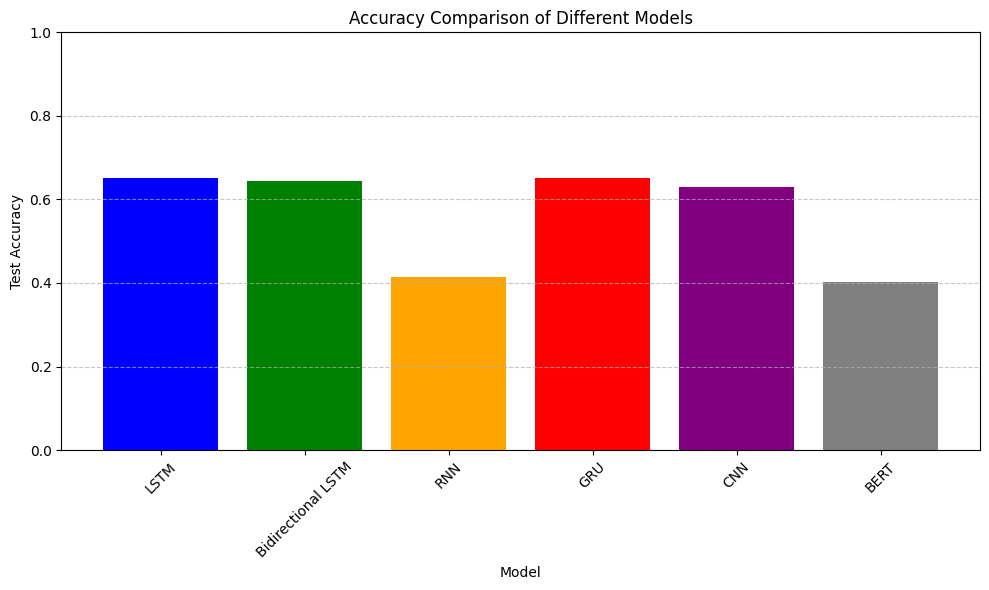

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy results
plt.figure(figsize=(10, 6))
plt.bar(df_accuracy["Model"], df_accuracy["Test Accuracy"], color=['blue', 'green', 'orange', 'red', 'purple', 'gray'])
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

111/111 [==============================] - 17s 153ms/step


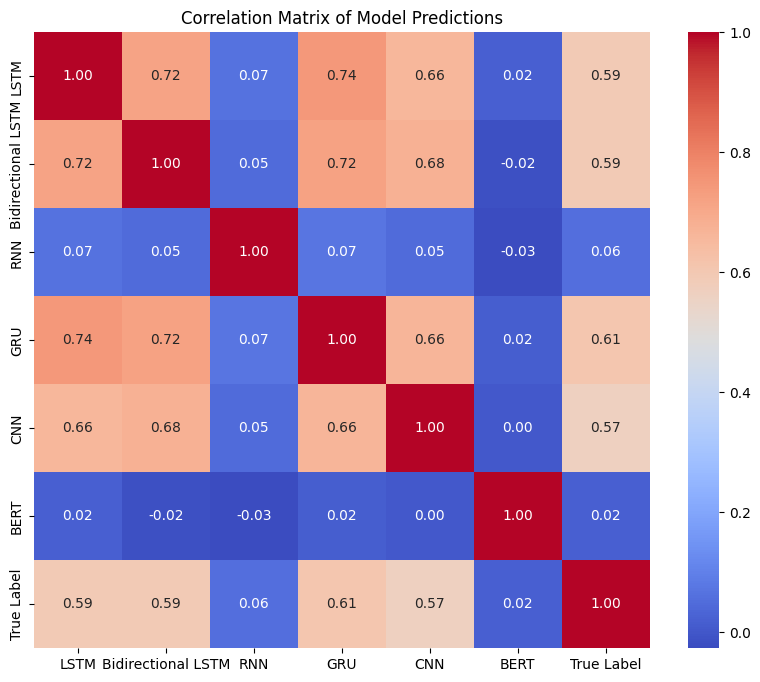

In [ ]:
import numpy as np
import seaborn as sns

# Make predictions for each model
lstm_preds = np.argmax(lstm_model.predict(X_test), axis=1)
bi_lstm_preds = np.argmax(bi_lstm_model.predict(X_test), axis=1)
rnn_preds = np.argmax(rnn_model.predict(X_test), axis=1)
gru_preds = np.argmax(gru_model.predict(X_test), axis=1)
cnn_preds = np.argmax(cnn_model.predict(X_test), axis=1)
bert_preds = np.argmax(bert_model.predict(X_test_tokens)[0], axis=1)

# Create a DataFrame to store the predictions
df_preds = pd.DataFrame({
    "LSTM": lstm_preds,
    "Bidirectional LSTM": bi_lstm_preds,
    "RNN": rnn_preds,
    "GRU": gru_preds,
    "CNN": cnn_preds,
    "BERT": bert_preds,
    "True Label": y_test
})

# Calculate the correlation matrix
correlation_matrix = df_preds.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title('Correlation Matrix of Model Predictions')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


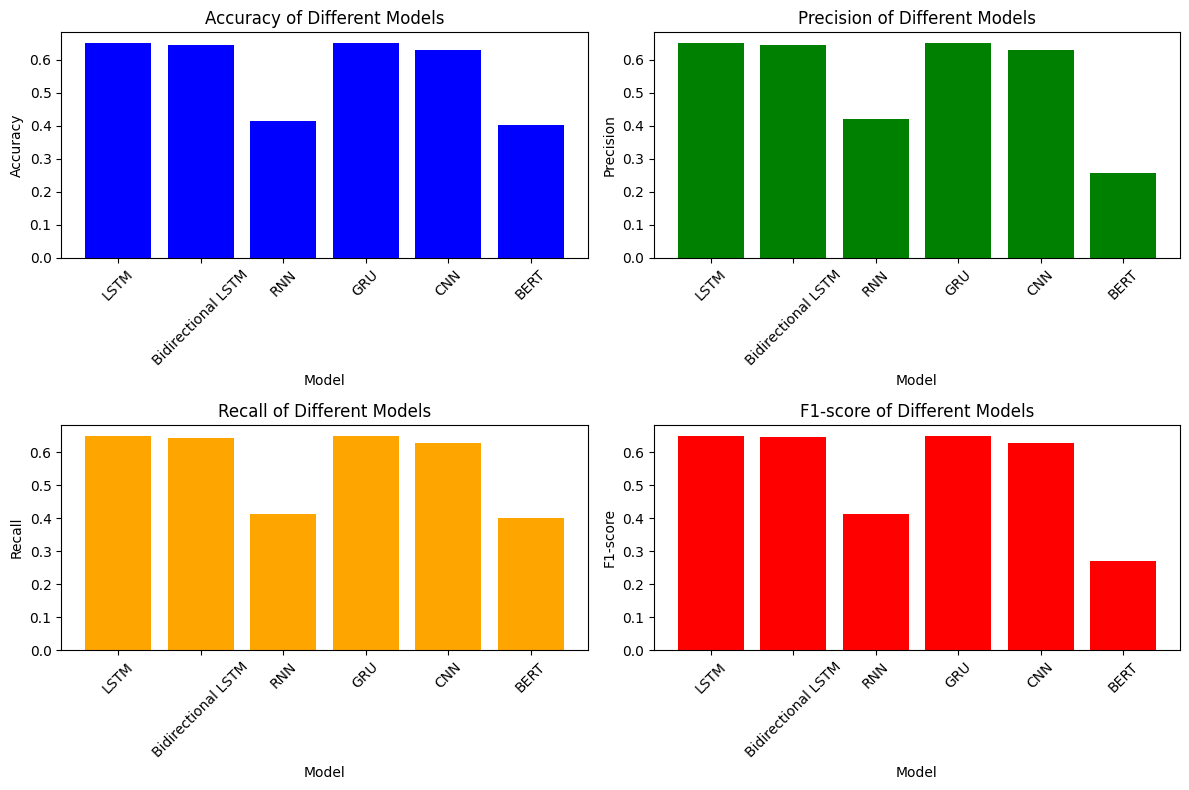

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute performance metrics for each model
metrics_dict = {
    "Model": ["LSTM", "Bidirectional LSTM", "RNN", "GRU", "CNN", "BERT"],
    "Accuracy": [accuracy_score(y_test, lstm_preds),
                 accuracy_score(y_test, bi_lstm_preds),
                 accuracy_score(y_test, rnn_preds),
                 accuracy_score(y_test, gru_preds),
                 accuracy_score(y_test, cnn_preds),
                 accuracy_score(y_test, bert_preds)],
    "Precision": [precision_score(y_test, lstm_preds, average='weighted'),
                  precision_score(y_test, bi_lstm_preds, average='weighted'),
                  precision_score(y_test, rnn_preds, average='weighted'),
                  precision_score(y_test, gru_preds, average='weighted'),
                  precision_score(y_test, cnn_preds, average='weighted'),
                  precision_score(y_test, bert_preds, average='weighted')],
    "Recall": [recall_score(y_test, lstm_preds, average='weighted'),
               recall_score(y_test, bi_lstm_preds, average='weighted'),
               recall_score(y_test, rnn_preds, average='weighted'),
               recall_score(y_test, gru_preds, average='weighted'),
               recall_score(y_test, cnn_preds, average='weighted'),
               recall_score(y_test, bert_preds, average='weighted')],
    "F1-score": [f1_score(y_test, lstm_preds, average='weighted'),
                 f1_score(y_test, bi_lstm_preds, average='weighted'),
                 f1_score(y_test, rnn_preds, average='weighted'),
                 f1_score(y_test, gru_preds, average='weighted'),
                 f1_score(y_test, cnn_preds, average='weighted'),
                 f1_score(y_test, bert_preds, average='weighted')]
}

# Create a DataFrame for the metrics
df_metrics = pd.DataFrame(metrics_dict)

# Plot the performance metrics
plt.figure(figsize=(12, 8))

# Accuracy
plt.subplot(2, 2, 1)
plt.bar(df_metrics["Model"], df_metrics["Accuracy"], color='blue')
plt.title('Accuracy of Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

# Precision
plt.subplot(2, 2, 2)
plt.bar(df_metrics["Model"], df_metrics["Precision"], color='green')
plt.title('Precision of Different Models')
plt.xlabel('Model')
plt.ylabel('Precision')
plt.xticks(rotation=45)

# Recall
plt.subplot(2, 2, 3)
plt.bar(df_metrics["Model"], df_metrics["Recall"], color='orange')
plt.title('Recall of Different Models')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.xticks(rotation=45)

# F1-score
plt.subplot(2, 2, 4)
plt.bar(df_metrics["Model"], df_metrics["F1-score"], color='red')
plt.title('F1-score of Different Models')
plt.xlabel('Model')
plt.ylabel('F1-score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
